In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import (
 cross_val_score,
 cross_validate,
 train_test_split,
 GridSearchCV,
 RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from xgboost import XGBRegressor
import shap
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')


RendererRegistry.enable('mimetype')

### Transform data 

In [2]:
X_train = pd.read_csv("../data/raw/X_train.csv", parse_dates=['year'])
X_train['year'] = X_train['year'].dt.year
y_train = pd.read_csv("../data/raw/y_train.csv")
train_df = X_train.join(y_train.set_index('carID'), on = "carID")

In [3]:
train_df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         4960 non-null   int64  
 1   brand         4960 non-null   object 
 2   model         4960 non-null   object 
 3   year          4960 non-null   int64  
 4   transmission  4960 non-null   object 
 5   mileage       4960 non-null   int64  
 6   fuelType      4960 non-null   object 
 7   tax           4960 non-null   float64
 8   mpg           4960 non-null   float64
 9   engineSize    4960 non-null   float64
 10  price         4960 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 426.4+ KB


In [5]:
drop_features = ["carID"]
categorical_features = ["brand", "model", "transmission", "fuelType"]
ordinal_features = ["year"]
target = "price"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set(categorical_features)
    - set(ordinal_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + categorical_features
    + numeric_features
    + ordinal_features
    + [target]
)

In [6]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan), ordinal_features),
    ("drop", drop_features))

In [7]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]

In [8]:
scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2"}

In [9]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['engineSize', 'mileage', 'mpg', 'tax']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['brand', 'model', 'transmission',
                                  'fuelType']),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['year']),
                                ('drop', 'drop', ['carID'])])

### Models

#### baseline

In [10]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [11]:
results ={}

In [12]:
dummy = DummyRegressor()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

In [13]:
pd.DataFrame(results)

,Dummy
fit_time,0.001 (+/- 0.000)
score_time,0.000 (+/- 0.000)
test_neg RMSE,-16394.964 (+/- 837.605)
train_neg RMSE,-16403.194 (+/- 211.166)
test_r2,-0.003 (+/- 0.002)
train_r2,0.000 (+/- 0.000)


In [14]:
pipe_lr = make_pipeline(
    preprocessor, Ridge(random_state=123)
)

pipe_ls = make_pipeline(
    preprocessor, Lasso(random_state=123)
)

pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=123)
)

pipe_xgboost = make_pipeline(
    preprocessor, XGBRegressor(random_state=123, verbose = 0)
)

In [15]:
models = {
    "linear regression": pipe_lr,
    "lasso": pipe_ls,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgboost
}

In [16]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

[19:22:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:22:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:22:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:22:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:22:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



In [17]:
pd.DataFrame(results)

,Dummy,linear regression,lasso,random forest,XGBoost
fit_time,0.001 (+/- 0.000),0.023 (+/- 0.002),0.319 (+/- 0.128),3.948 (+/- 0.048),0.414 (+/- 0.013)
score_time,0.000 (+/- 0.000),0.005 (+/- 0.000),0.005 (+/- 0.001),0.023 (+/- 0.001),0.008 (+/- 0.001)
test_neg RMSE,-16394.964 (+/- 837.605),-5675.983 (+/- 337.090),-5658.611 (+/- 331.754),-3363.222 (+/- 166.554),-3282.338 (+/- 140.302)
train_neg RMSE,-16403.194 (+/- 211.166),-5530.901 (+/- 79.267),-5509.342 (+/- 80.501),-1361.220 (+/- 36.731),-1581.720 (+/- 57.040)
test_r2,-0.003 (+/- 0.002),0.880 (+/- 0.005),0.881 (+/- 0.006),0.958 (+/- 0.004),0.960 (+/- 0.003)
train_r2,0.000 (+/- 0.000),0.886 (+/- 0.001),0.887 (+/- 0.001),0.993 (+/- 0.001),0.991 (+/- 0.001)


In [18]:
pipe_xgboost.fit(X_train, y_train)

[19:22:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['engineSize', 'mileage',
                                                   'mpg', 'tax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model',
                                                   'transmission',
                                                   'fuelType']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['year']...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=123, ...))])

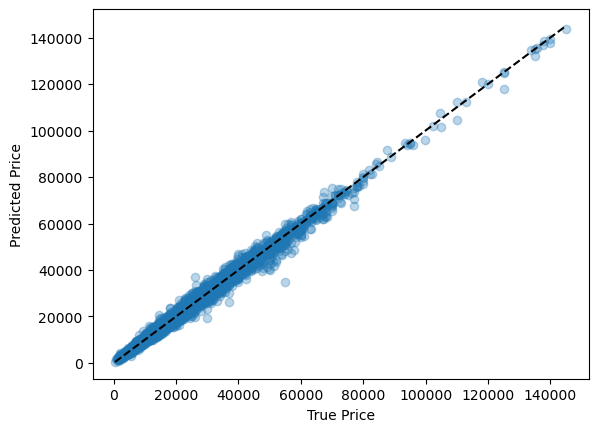

In [19]:
plt.scatter(y_train, pipe_xgboost.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("True Price")
plt.ylabel("Predicted Price");

In [20]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['engineSize', 'mileage', 'mpg', 'tax']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['brand', 'model', 'transmission',
                                  'fuelType']),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['year']),
                                ('drop', 'drop', ['carID'])])

In [21]:
feature_names = (
    numeric_features
    + list(
        pipe_lr.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names_out()
    )
    + ordinal_features)

In [22]:
X_train_encode = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_encode.head()

,engineSize,mileage,mpg,tax,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,...,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,year
0,0.095814,-0.848304,-0.295744,-0.088993,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,22.0
1,-0.157579,0.937516,0.272200,-0.331725,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.0
2,0.982689,-0.810335,-0.595105,-0.088993,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0
3,-0.157579,-0.185480,0.202256,-1.484700,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19.0
4,-1.424542,-0.875062,-0.091508,-0.088993,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,23.0


In [28]:
pipe_xgboost.fit(X_train, y_train)

[19:30:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['engineSize', 'mileage',
                                                   'mpg', 'tax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model',
                                                   'transmission',
                                                   'fuelType']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['year']...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=123, ...))])

In [31]:
pipe_xgboost.named_steps

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  ['engineSize', 'mileage', 'mpg', 'tax']),
                                 ('onehotencoder',
                                  OneHotEncoder(dtype='int',
                                                handle_unknown='ignore'),
                                  ['brand', 'model', 'transmission',
                                   'fuelType']),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=nan),
                                  ['year']),
                                 ('drop', 'drop', ['carID'])]),
 'xgbregressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorica

In [32]:
xgboost_explainer = shap.TreeExplainer(pipe_xgboost.named_steps["xgbregressor"])
train_xgboost_shap_values = xgboost_explainer.shap_values(X_train_encode)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


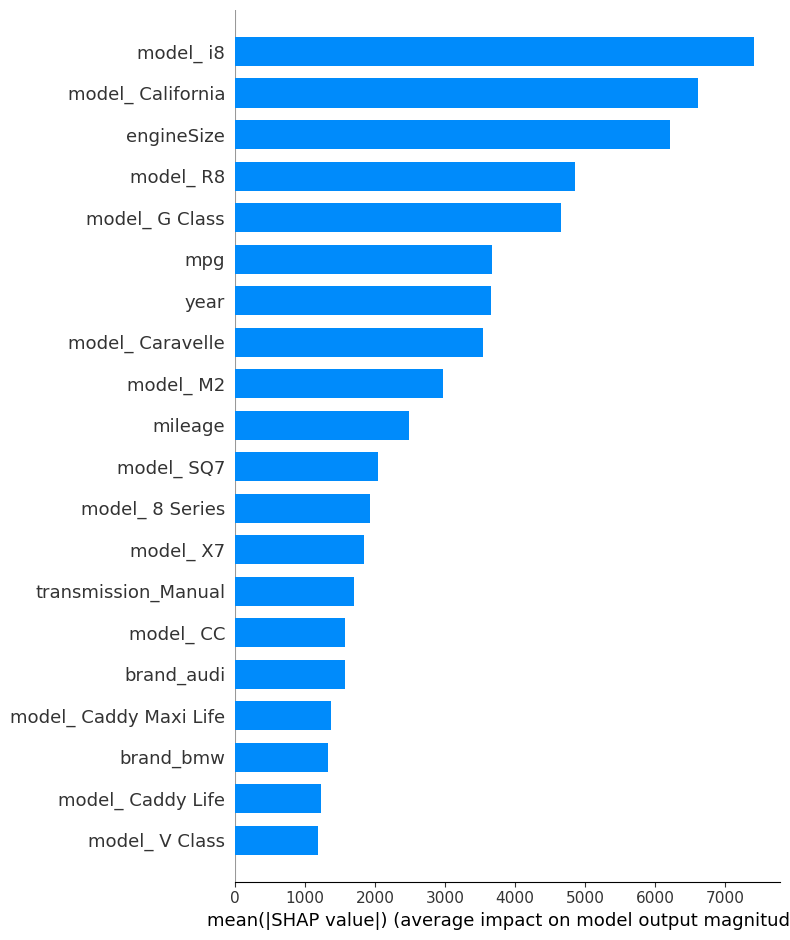

In [34]:
shap.summary_plot(train_xgboost_shap_values, X_train_encode, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


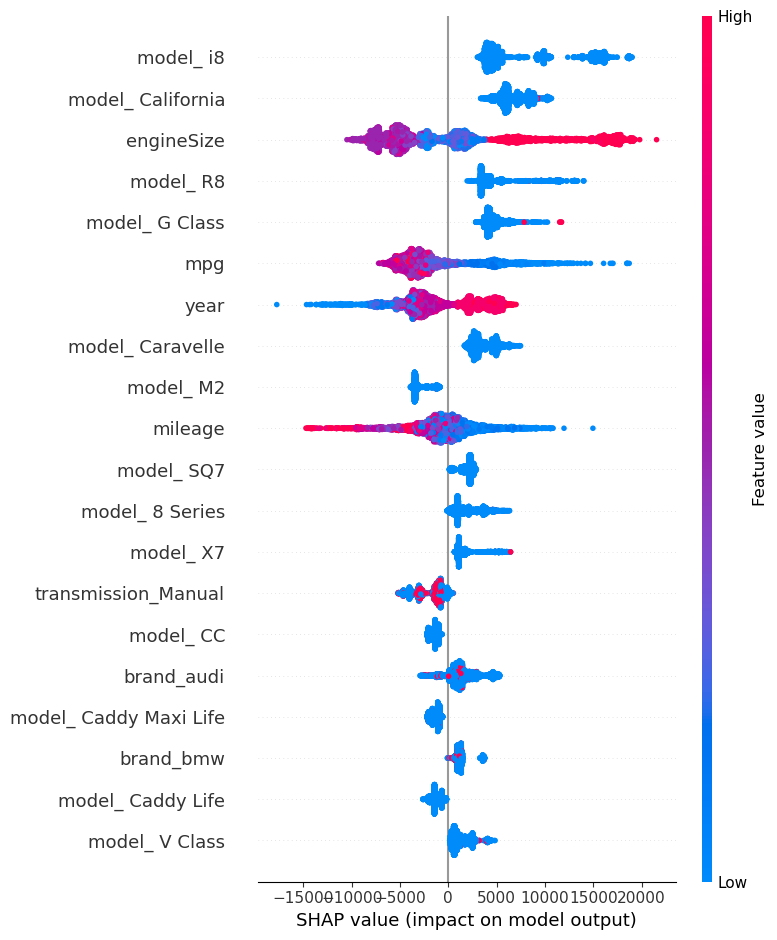

In [35]:
shap.summary_plot(train_xgboost_shap_values, X_train_encode)

In [ ]:
X_test = pd.read_csv("../data/raw/X_test.csv", parse_dates=['year'])
X_test['year'] = X_test['year'].dt.year
y_test = pd.read_csv("../data/raw/y_test.csv")

In [ ]:
X_test_encode = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

In [ ]:
test_catboost_shap_values = catboost_explainer.shap_values(X_test_encode)

In [ ]:
X_test_encode = X_test_encode.round(2)

In [ ]:
shap.force_plot(
    catboost_explainer.expected_value,
    test_catboost_shap_values[8],
    X_test_encode.loc[8, :],
    matplotlib=True,
)

In [ ]:
y_predict = pipe_catboost.predict(X_test)

In [ ]:
y_predict

In [ ]:
r2_score(y_test['price'], y_predict)